# Different Solutions for 1-Dimensional-1-Phase Problem

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1-5ztISn_pEuNjBWLEckyimFk1pDJf9wc/view?usp=drive_link&target=_blank)

*Author: Zakariya Abugrin | Date: May 2025*

In [1]:
# Colab only:
try:
    # Install reservoirflow in Colab
    import os
    import google.colab
    !pip install reservoirflow
    # Restart session after installation
    os.kill(os.getpid(), 9)
    print("Session was restarted.")
    print("Now you can run to the following cells.")
except ImportError:
    pass

## Introduction

The solution for a simple 1-dimensional-1-phase (1D1P) problem is available in all solutions which includes: `analytical`, `numerical`, `neurical`. In tutorial, we will see how we can build all solutions and compare them together. 

## Prerequisites:
Before you can follow this tutorial, you need to understand the following tutorials:
1. [Understand scalers Module](/user_guide/tutorials/tutorial_understand_scalers_module.html).
2. [Understand Compiling](/user_guide/tutorials/tutorial_understand_compiling.html).

## Import `reservoirflow`

We start with importing `reservoirflow` as `rf`. The abbreviation `rf` refers to `reservoirflow` where all modules under this library can be accessed. `rf` is also used throughout the [API](/api/API.html) documentation. We recommend our users to stick with this convention.

In [2]:
import reservoirflow as rf
import numpy as np

print(rf.__version__)

0.1.0b3


## Build a model

A reservoir simulation model requires two objects: `Grid` and `Fluid`. The function below `create_model()` starts by creating these objects which are used to initiate a `Model` object using [`BlackOil`](/api/reservoirflow.models.BlackOil.html) class. 

In [3]:
def create_model(nx=101, n_w=2, comp=False):
    # Compressibility:
    if comp:
        g_comp = 1 * 10**-6
        f_comp = 1 * 10**-5
    else:
        g_comp = None
        f_comp = None
    # Grid:
    grid = rf.grids.RegularCartesian(
        nx=nx,
        ny=1,
        nz=1,
        dx=300,
        dy=350,
        dz=40,
        phi=0.27,
        kx=270,
        comp=g_comp,
        dtype="double",
    )
    # Fluid:
    fluid = rf.fluids.SinglePhase(
        mu=0.5,
        B=1,
        comp=f_comp,
        dtype="double",
    )
    # Model:
    model = rf.models.BlackOil(
        grid, fluid, pi=4000, dtype="double", dt=1, verbose=False
    )
    # Wells:
    if n_w > 0:
        well_ids = np.cumsum([nx // (n_w + 1) for i in range(n_w)])
        print("Wells_ids:", well_ids)
        for well_id in well_ids:
            # model.set_well(id=well_id, q=-600, s=1.5, r=3.5)
            model.set_well(id=well_id, pwf=1000, s=1.5, r=3.5)
        # Boundaries:
        model.set_boundaries({
            0: ("pressure", 4000),  # left boundary
            nx + 1: ("pressure", 4000), # right boundary
            })
    else:
        # Boundaries:
        model.set_boundaries({
            0: ("pressure", 4000), # left boundary
            nx + 1: ("pressure", 1000), # right boundary
            })

    return model

Lets create the model:

In [4]:
model = create_model(n_w=0, comp=True)
print("Current solutions:", model.solutions)

Current solutions: {}


```{note}
When a model is created, compiled solutions are made available under the dictionary ``model.solutions`` after executed (i.e. ``model.run()``). The model always switches to the latest compiled solution. To change to previous solutions, ``model.set_solution()`` can be used with the solution names same as shown in the dictionary ``model.solutions``.
```

## Define Scalers

Scaling is an important feature in `reservoirflow` and has many applications. Most important: to allow bringing different solutions to the same domains.

Before we compile the model to different solutions, we can show and setup the scaling for different features as shown in [Understand scalers Module](/user_guide/tutorials/tutorial_understand_scalers_module.html). Scalers are defined by default and can be accessed using `model.scalers_dict` as following: 

In [5]:
model.scalers_dict  # model.get_scalers()

{'time': ['MinMax', (0, 1)],
 'space': ['MinMax', (-1, 1)],
 'pressure': ['MinMax', (-1, 1)],
 'rate': [None, None]}

We can use `model.set_scalers()` to change the scaling for one or several variables as following:

In [6]:
model.set_scalers({"time":("MinMax", (0,1000))})
model.scalers_dict

{'time': ['MinMax', (0, 1000)],
 'space': ['MinMax', (-1, 1)],
 'pressure': ['MinMax', (-1, 1)],
 'rate': [None, None]}

```{note}
To exclude variables from scaling, `None` value is used which is the case for `rate` in the example above. 
```

## Compile the model

Before you can run the model, you need to compile a solution for it. By compiling a solution, you actually decide the solution you want to use for your model. Interestingly, `reservoirflow` provides multiple solutions for the same model based on your configuration, see [Understand Compiling](/user_guide/tutorials/tutorial_understand_compiling.html).

After the model is compiled, method `model.run()` will be available. Solutions might have different configurations available under this method. However, we can define common configuration for all solutions as a dictionary:


In [7]:
common_run_config = dict(
    nsteps=100,
    vectorize=True,
)

```{tip}
In common run configuration, you would include parameters that are shared by all models such as `nsteps`.
```

### Numerical Solution

We can compile the model using the numerical solution based on Finite-Difference-Method (FDM). This solution can be obtained as following:

In [8]:
model.compile(
    stype="numerical", # solution typle
    method="FDM", # solution method
    sparse=True, # sparse matrix
    name=f"Numerical (Nx=101)", # name of the solution
)

[info] FDM was assigned as model.solution.


Now that the solution was compiled without issues, the model can be run for the number of `nsteps`: 

In [9]:
model.run(**common_run_config)

[info] Simulation run started: 100 timesteps.


[step]: 100%|██████████| 100/100 [00:00<00:00, 315.38steps/s]

[info] Simulation run of 100 steps finished in 0.33 seconds.
[info] Material Balance Error: 7.602807272633072e-13.


Results can be shown for the complied solutions as following: 

[Info] Solution: Numerical (Nx=101) was added.


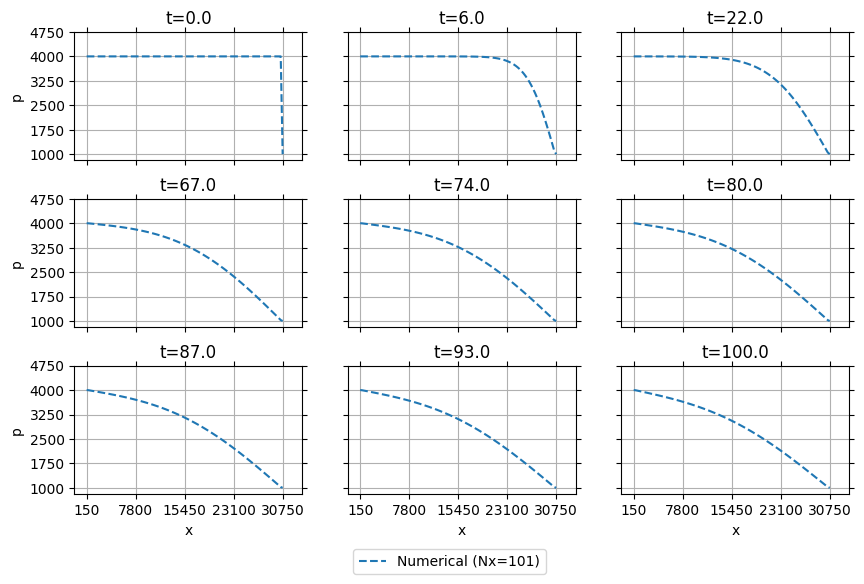

In [10]:
model.plot(scale=False, boundary=True)

```{note}
Values are shown with scaling `scaling=False` and boundaries `boundaries=True`.
```

[Info] Solution: Numerical (Nx=101) was added.


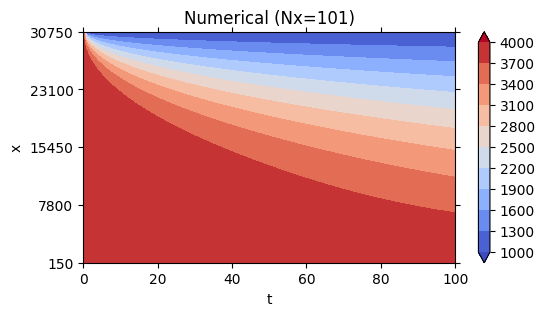

In [11]:
model.plot(type="contour", scale=False, boundary=True)

### Analytical Solution

This is a single phase fluid flow in 1D with a defined boundaries. The analytical solution of this problem is characterized as homogeneous PDE with nonhomogeneous BC and can be obtained as following:

[](reference) <!-- (ch04_homogeneousPDE_nonhomogeneousBC_12) -->

$
u(x,t) = u_0 + \frac{u_L - u_0}{L}x +
\frac{2}{\pi} \, \sum_{n=1}^{\infty}
\biggr[(u_i - u_0)\frac{1}{n} + (u_L-u_i)\frac{(-1)^n}{n} \biggr ] \,
\sin(\frac{n \pi x}{L}) \, e^{-{\frac{n^2 \pi^2}{L^2}} \alpha t} 
\qquad \text{where} \quad n \in \mathbb{N}
$

The exact solution is approached as $N \to \infty$ (i.e. Lower N values give poor results).

This solution can be selected by compiling the model as following: 

In [12]:
N = 2  # Number of terms in the analytical solution
model.compile(
    stype="analytical", 
    method="1D1P", 
    sparse=True, 
    name=f'Analytical (N={N})',
)

[info] D1P1 was assigned as model.solution.


Now that the solution was compiled without issues, the model can be run for the number of `nsteps` and the provided `N`: 

In [13]:
model.run(**common_run_config | {"N": N, "clean": False})

[info] Simulation run started: 100 timesteps.


[step]: 100%|██████████| 2/2 [00:00<00:00, 1026.63steps/s]

[info] Simulation run of 100 steps finished in 0.01 seconds.


Results can be shown for the complied solutions as following: 

[Info] Solution: Analytical (N=2) was added.


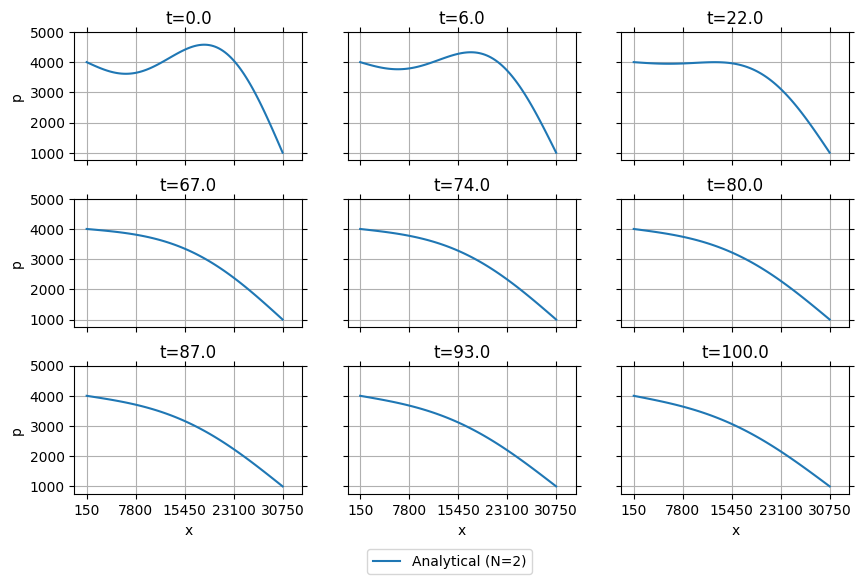

In [14]:
model.plot(scale=False, boundary=True)

```{note}
Values are shown without scaling `scaling=False` but with boundaries `boundaries=True`.
```

We can improve the analytical solution by using `N=200` and `clean=True` which will exclude values outside of the defined range. 

In [15]:
N = 1600  # Number of terms in the analytical solution
model.compile(
    stype="analytical",
    method="1D1P",
    sparse=True,
    name=f"Analytical (N={N})",
)

[info] D1P1 was assigned as model.solution.


In [16]:
common_run_config = dict(
    nsteps=100,
    vectorize=True,
    threading=True,
)
model.run(**common_run_config | {"N": N, "clean": True})

[info] Simulation run started: 100 timesteps.


[step]: 100%|██████████| 1600/1600 [00:00<00:00, 89984.80steps/s]


[info] Simulation run of 100 steps finished in 0.27 seconds.


[Info] Solution: Analytical (N=1600) was added.


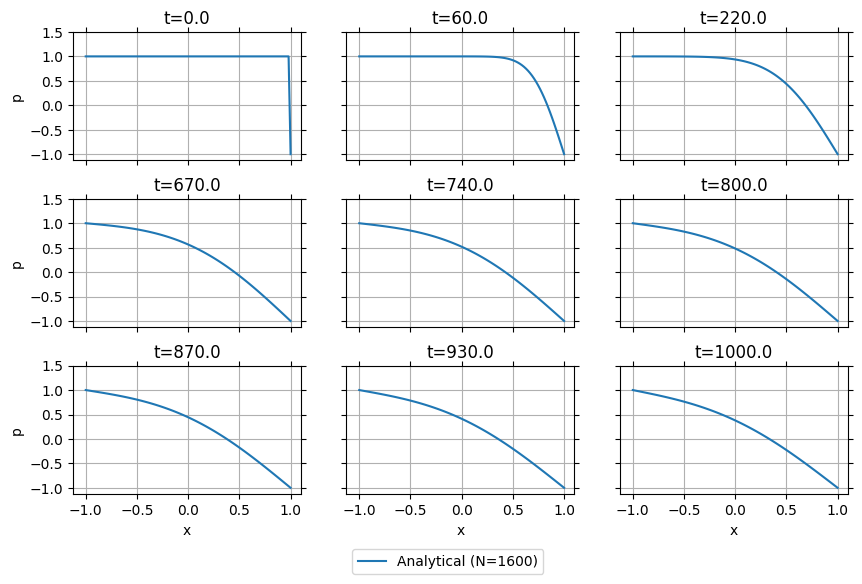

In [17]:
model.plot(scale=True, boundary=True)

```{note}
Values are shown with scaling `scaling=True` but with boundaries `boundaries=True`. Scaled values should match what we defined earlier in `model.set_scalers()` method.
```

[Info] Solution: Analytical (N=1600) was added.


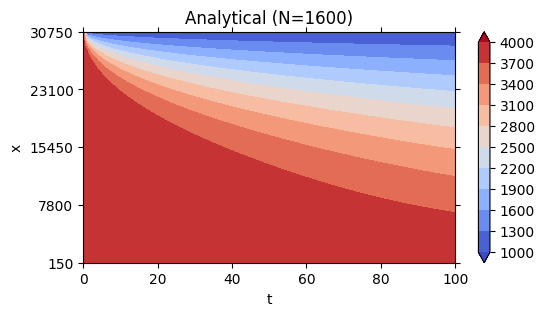

In [18]:
model.plot(type="contour", scale=False, boundary=True)

## Comparing Solutions

First, we check all available solution for the model using `model.print_solutions()` as follows:

In [19]:
model.print_solutions()

╭────┬─────────────────────┬────────────┬──────────┬──────────┬─────────┬──────────╮
│    │ name                │ stype      │ method   │ sparse   │   tstep │   nsteps │
├────┼─────────────────────┼────────────┼──────────┼──────────┼─────────┼──────────┤
│  0 │ Numerical (Nx=101)  │ Numerical  │ FDM      │ True     │     100 │      101 │
│  1 │ Analytical (N=2)    │ Analytical │ D1P1     │ True     │     100 │      101 │
│  2 │ Analytical (N=1600) │ Analytical │ D1P1     │ True     │     100 │      101 │
╰────┴─────────────────────┴────────────┴──────────┴──────────┴─────────┴──────────╯
(*)
 - stype: solution type.
 - method: solution method.
 - sparse: whether the solution uses sparse computing.
 - tstep: last time step.
 - nsteps: total number of steps in the solution.



Method `model.plot()` takes the last complied solution. You can use `model.set_solution(name)` to switch to another solution. Or use `model.plot(solution)` to explicitly define the solution name you want to plot. For example: 

[Info] Solution: Analytical (N=2) was added.


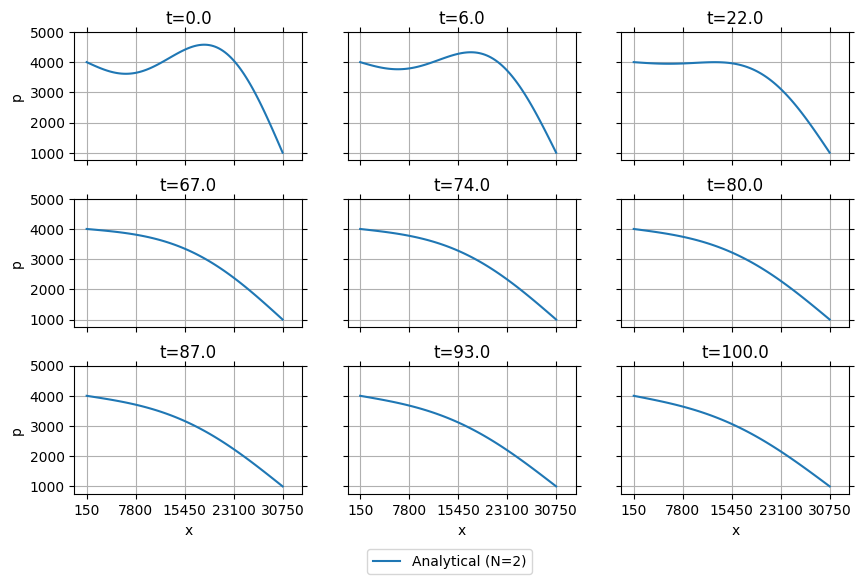

In [20]:
model.plot(type='line', solution="Analytical (N=2)")  # model.plot(solution="Numerical (Nx=101)")

[Info] Solution: Analytical (N=2) was added.


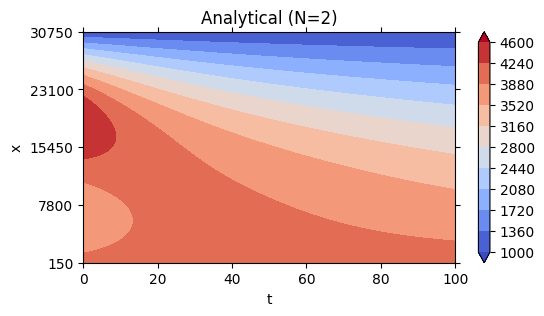

In [21]:
model.plot(type="contour", scale=False, boundary=True, solution="Analytical (N=2)")

Another feature is to plot `all` solutions together for comparison as follows: 

[Info] Solution: Numerical (Nx=101) was added.
[Info] Solution: Analytical (N=2) was added.
[Info] Solution: Analytical (N=1600) was added.


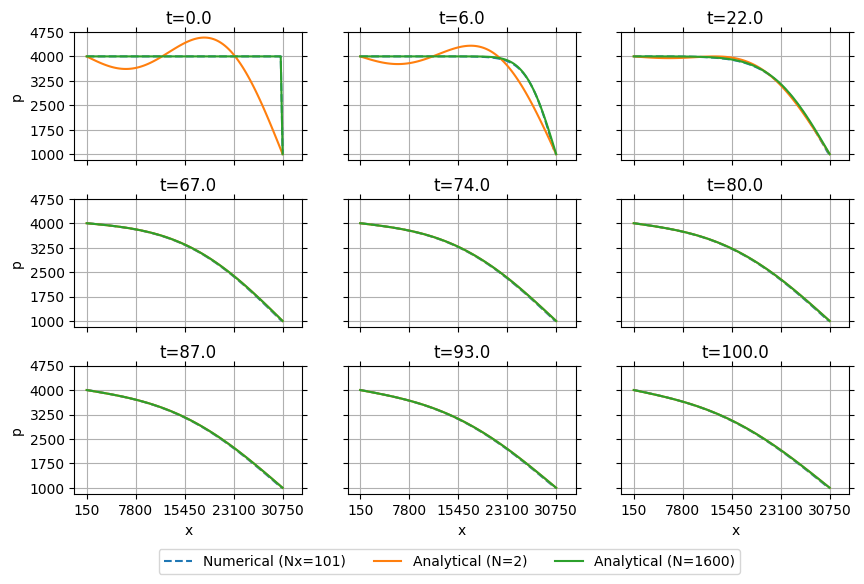

In [22]:
model.plot(solution="all")  # or model.plot_solutions()

## Comparing Solutions (Contour Plot)

In [23]:
model.get_df(
    melt=True,
    columns=["time", "cells_pressure"],
    scale=False,
    boundary=True,
    drop_nan=False,
)

,id,Step,x,Time,P
0,0,0,150.0,0,4000.000000
1,1,0,450.0,0,4000.000000
2,2,0,750.0,0,4000.000000
3,3,0,1050.0,0,4000.000000
4,4,0,1350.0,0,4000.000000
...,...,...,...,...,...
10398,98,100,29550.0,100,1189.274996
10399,99,100,29850.0,100,1142.020379
10400,100,100,30150.0,100,1094.710814
10401,101,100,30450.0,100,1047.364580


In [24]:
import numpy as np


def logarithmic_scaling(x, min_range, max_range, c=1):
    scaled_value = (
        (np.log(x + c) - np.log(X.min() + c))
        / (np.log(X.max() + c) - np.log(X.min() + c))
    ) * (max_range - min_range) + min_range
    return scaled_value


# Example usage
X = np.array([1, 10, 100, 1000])

min_range = 0  # Replace with your desired minimum range
max_range = 1  # Replace with your desired maximum range

scaled_X = logarithmic_scaling(X, min_range, max_range)

print(scaled_X)


def inverse_logarithmic_scaling(scaled_value, min_range, max_range, c=1):
    original_value = (
        np.exp(
            (
                (scaled_value - min_range)
                * (np.log(X.max() + c) - np.log(X.min() + c))
                / (max_range - min_range)
            )
            + np.log(X.min() + c)
        )
        - c
    )
    return original_value


# Example usage
scaled_X = np.array([0, 0.5, 0.8, 1])  # Replace with your scaled values
min_range = 0  # Replace with your specified minimum range
max_range = 1  # Replace with your specified maximum range

original_X = inverse_logarithmic_scaling(scaled_X, min_range, max_range)

print(original_X)

[0.         0.27426894 0.63098792 1.        ]
[   1.           43.74371464  287.77079009 1000.        ]


```{include} /_static/comments_section.md
```